In [1]:
# enable reload the module
%load_ext autoreload
%autoreload 2

In [4]:
from tools.mtr_inference import MTRInference
import torch
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
import numpy as np
from torch.distributions import MultivariateNormal

# Interesting case:
1. Val, 6, 2d84b1ab55ab81d3, U-turn vs Left-turn
2. Val, 7, 3505972c220e6b3a, Turn vs Striaght for merging
3. Val, 25, 6d2a107f2e8390a, Merge to main road
4. Val, 26, ae92386e0686d4d6, Complicated 4-way stop
5. Val, 27, 3d00a93f0ba5e294, Both car merge to main road
6. Val, 36, 31d18fac4011375c, illegal merging to the main road

In [6]:
cfg_file = 'tools/cfgs/waymo/bc+10_percent_data.yaml'
ckpt_path = 'output/bc/epoch=2-step=4602.ckpt'
mtr_inference = MTRInference(cfg_file)
mtr_inference.load_from_checkpoint(ckpt_path)

=========== MTR Inference ===========


In [ ]:
def sample_multimodal_gaussian(params, scores, num_samples=1000):
    mean = params[..., 0:3]
    log_std = params[..., 3:6]
    std = np.exp(log_std)
    rho = params[..., 6:]
    
    # [batch_size, mode, 3, 3]
    cov = np.array([[std[..., 0]**2, rho[..., 0]*std[..., 0]*std[..., 1], rho[..., 1]*std[..., 0]*std[..., 2]],
                    [rho[..., 0]*std[..., 0]*std[..., 1], std[..., 1]**2, rho[..., 2]*std[..., 1]*std[..., 2]],
                    [rho[..., 1]*std[..., 0]*std[..., 2], rho[..., 2]*std[..., 1]*std[..., 2], std[..., 2]**2]])
    
    

In [10]:
index = 0
shift = 35
scene_id, info, data_batch = mtr_inference.generate_input_data(index, shift)
batch_pred_dicts = mtr_inference.inference(data_batch)
# print(batch_pred_dicts['input_dict'].keys())
pred_ctrl_scores = torch.functional.F.softmax(batch_pred_dicts['pred_ctrl_scores'], dim=-1)
pred_ctrl = batch_pred_dicts['pred_ctrl'].cpu().numpy()
pred_trajs = batch_pred_dicts['pred_trajs'].cpu().numpy()

/tmp/ipykernel_3344711/3092629701.py:22: RuntimeWarning: covariance is not positive-semidefinite.
  sample = np.random.multivariate_normal(mean[car, i], cov[car, i], count)


(1.56400990965689,
 1.9283566216156918,
 -0.02221988908590713,
 0.0018886711921822323)

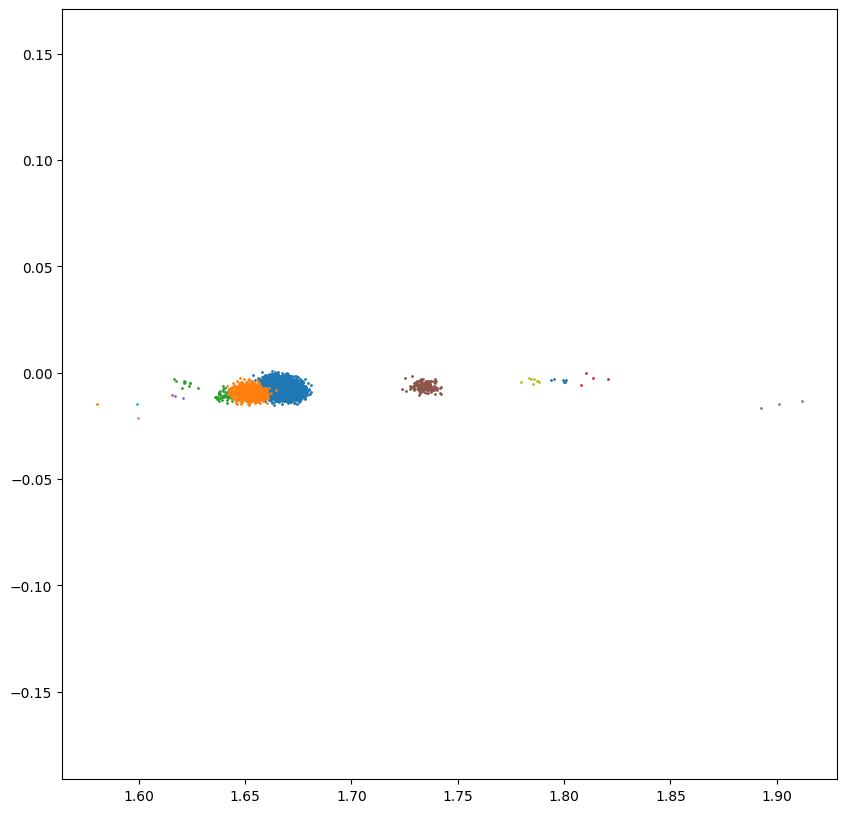

In [103]:
car = 2
n = 10000
rnd_choice = np.random.choice(pred_ctrl.shape[1], n, p=pred_ctrl_scores[car, :])
histgram = np.histogram(rnd_choice, bins=range(pred_ctrl.shape[1]+1))[0]



mean = pred_ctrl[..., 0:3]
log_std = pred_ctrl[..., 3:6]
std = np.exp(log_std)
rho = pred_ctrl[..., 6:]

# [batch_size, mode, 3, 3]
cov = np.array([[std[..., 0]**2, rho[..., 0]*std[..., 0]*std[..., 1], rho[..., 1]*std[..., 0]*std[..., 2]],
                [rho[..., 0]*std[..., 0]*std[..., 1], std[..., 1]**2, rho[..., 2]*std[..., 1]*std[..., 2]],
                [rho[..., 1]*std[..., 0]*std[..., 2], rho[..., 2]*std[..., 1]*std[..., 2], std[..., 2]**2]]).transpose(2, 3, 0, 1)

plt.figure(figsize=(10, 10))

for i, count in enumerate(histgram):
    if count > 0:
        sample = np.random.multivariate_normal(mean[car, i], cov[car, i], count)
        plt.scatter(sample[:, 0], sample[:, 1], s=1)
        
# for i in range(pred_trajs.shape[1]):
    # plt.plot(pred_trajs[car, i, :10, 0], pred_trajs[car, i, :10, 1], c='r')
        
plt.axis('equal')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 index = 1                                                                                    │
│   2 scene_id, info = mtr_inference.generate_info(index)                                          │
│   3 shift = 35                                                                                   │
│ ❱ 4 mtr_inference.visualize(scene_id, info, shift=shift)                                         │
│   5                                                                                              │
│   6                                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_inference.py:181 in visualize                        │
│                                                                                                  │
│   178 │   │   # Run inference                                                                    │
│   179 │   │   final_pred_dicts = self.inference(data_batch)                                      │
│   180 │   │                                                                                      │
│ ❱ 181 │   │   fig, ax = self.plot_result(scene_id, info, final_pred_dicts, shift, plot_gt)       │
│   182 │   │                                                                                      │
│   183 │   │   return scene_id, fig, ax                                                           │
│   184                                                                                            │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_inference.py:149 in plot_result                      │
│                                                                                                  │
│   146 │   │   track_infos = info['track_infos']                                                  │
│   147 │   │                                                                                      │
│   148 │   │   for prediction in final_pred_dicts:                                                │
│ ❱ 149 │   │   │   pred_trajs = prediction['pred_trajs']                                          │
│   150 │   │   │   pred_scores = prediction['pred_scores']                                        │
│   151 │   │   │   for future, score in zip(pred_trajs, pred_scores):                             │
│   152 │   │   │   │   ax.plot(future[:, 0], future[:, 1], color='xkcd:russet', linewidth=2, li   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: string indices must be integers

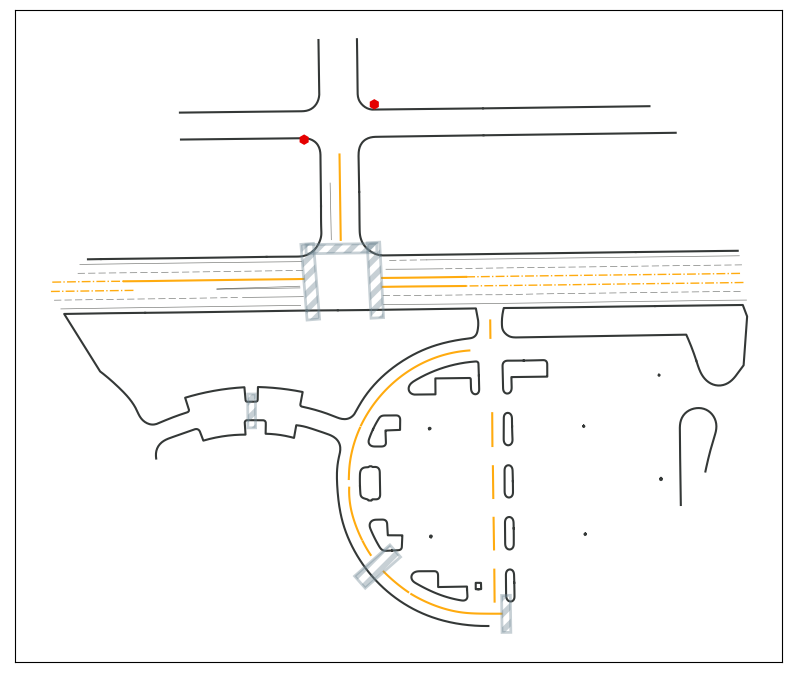

In [11]:

index = 1
scene_id, info = mtr_inference.generate_info(index)
shift = 35 
mtr_inference.visualize(scene_id, info, shift=shift)



In [33]:
mtr_inference.visualize(scene_id, info, shift=shift)
shift += 5


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 mtr_inference.visualize(scene_id, info, shift=shift)                                         │
│   2 shift += 5                                                                                   │
│   3                                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_inference.py:126 in visualize                        │
│                                                                                                  │
│   123 │   │   '''                                                                                │
│   124 │   │   Get the input data, run inference, and visualize the results.                      │
│   125 │   │   '''                                                                                │
│ ❱ 126 │   │   data = self.dataset.extract_scene_data(scene_id, info, shift)                      │
│   127 │   │                                                                                      │
│   128 │   │   # Make data in a batch with batch size 1                                           │
│   129 │   │   data_batch = self.dataset.collate_batch([data])                                    │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/mtr/datasets/waymo/waymo_dataset.py:122 in extract_scene_data  │
│                                                                                                  │
│   119 │   │                                                                                      │
│   120 │   │   # This function extract the current state of the objects that need to be           │
│   121 │   │   # predicted from the all objects' trajectories                                     │
│ ❱ 122 │   │   center_objects, track_index_to_predict = self.get_interested_agents(               │
│   123 │   │   │   track_index_to_predict=track_index_to_predict,                                 │
│   124 │   │   │   obj_trajs_full=obj_trajs_full,                                                 │
│   125 │   │   │   current_time_index=current_time_index,                                         │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/mtr/datasets/waymo/waymo_dataset.py:253 in                     │
│ get_interested_agents                                                                            │
│                                                                                                  │
│   250 │   │   │   center_objects_list.append(obj_trajs_full[obj_idx, current_time_index])        │
│   251 │   │   │   track_index_to_predict_selected.append(obj_idx)                                │
│   252 │   │                                                                                      │
│ ❱ 253 │   │   center_objects = np.stack(center_objects_list, axis=0)  # (num_center_objects, n   │
│   254 │   │   track_index_to_predict = np.array(track_index_to_predict_selected)                 │
│   255 │   │   return center_objects, track_index_to_predict                                      │
│   256                                                                                            │
│ in stack:5                                                                                       │
│                                                                                                  │
│ /home/zixuzhang/mambaforge/envs/lpp/lib/python3.9/site-pack